##### The cell below is for you to keep track of the libraries used and install those libraries quickly
##### Ensure that the proper library names are used and the syntax of `%pip install PACKAGE_NAME` is followed

In [ ]:
%pip install ipykernel
%pip install pandas 
%pip install numpy
%pip install pyarrow
%pip install fastparquet
%pip install matplotlib
%pip install scikit-learn
%pip install imbalanced-learn
%pip install xgboost
# add commented pip installation lines for packages used as shown above for ease of testing
# the line should be of the format %pip install PACKAGE_NAME 

## **DO NOT CHANGE** the filepath variable
##### Instead, create a folder named 'data' in your current working directory and 
##### have the .parquet file inside that. A relative path *must* be used when loading data into pandas

In [1]:
# Can have as many cells as you want for code
import pandas as pd
import numpy as np

# the initialised filepath MUST be a relative path to a folder named data that contains the parquet file
filepath = "./data/catB_train.parquet" 

### **ALL** Code for machine learning and dataset analysis should be entered below. 
##### Ensure that your code is clear and readable.
##### Comments and Markdown notes are advised to direct attention to pieces of code you deem useful.

### Drop Columns which are Unimportant

In [2]:
###...code...###
test_df = pd.read_parquet(filepath)

# drop columns that gave 1 unique value only
to_drop = []
for i in range(len(test_df.columns)):
    # if column has only 1 unique value, that column is unimportant as a feature
    if len(test_df[test_df.columns[i]].unique()) == 1:
        #print(len(test_df[test_df.columns[i]].unique()))
        to_drop.append(i)

dropped_df = test_df.drop(test_df.columns[to_drop], axis=1)
dropped_df.head()

,clntnum,race_desc,ctrycode_desc,clttype,stat_flag,min_occ_date,cltdob_fix,cltsex_fix,flg_substandard,flg_is_borderline_standard,...,recency_hlthclaim_success,hlthclaim_cnt_unsuccess,recency_hlthclaim_unsuccess,flg_hlthclaim_839f8a_ever,recency_hlthclaim_839f8a,flg_hlthclaim_14cb37_ever,recency_hlthclaim_14cb37,giclaim_amt,recency_giclaim,f_purchase_lh
19550,91b546e924,Chinese,Singapore,P,ACTIVE,2017-10-31,1974-05-09,Female,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN
4600,896bae548c,Chinese,Singapore,P,ACTIVE,2007-05-23,1979-11-11,Male,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN
13337,f364439ae6,Others,Singapore,P,ACTIVE,2019-08-31,1976-01-28,Male,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN
15074,70f319cfe1,Chinese,Singapore,P,ACTIVE,2021-10-18,1976-03-19,Female,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN
19724,2647a81328,Chinese,Singapore,P,ACTIVE,2018-07-20,1995-07-31,Female,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN


In [3]:
###...code...###
dropped_df["f_purchase_lh"] = dropped_df["f_purchase_lh"].fillna(0)

def handle_na(df):
    # Dropping columns where na values take up 65% of the column
    df_temp = df.dropna(thresh = dropped_df.shape[0]*0.2, axis = 1).copy()
    df_temp = df_temp.drop(['clntnum'], axis=1)

    # Try casting categorical columns to numeric to reduce encoding
    non_numeric_cols = df_temp.select_dtypes(include=["object"]).columns
    for i in range(len(non_numeric_cols)):
        try:
            df_temp[non_numeric_cols[i]] = pd.to_numeric(df_temp[non_numeric_cols[i]])
        except ValueError:
            continue
    non_numeric_cols = df_temp.select_dtypes(include=["object"]).columns

    # Extract year from columns containing dates
    df_temp['cltdob_fix'] = df_temp['cltdob_fix'].str[:4]
    df_temp['min_occ_date'] = df_temp['min_occ_date'].str[:4]

    # Fill NA values for categorical columns with 'Missing'
    df_temp[non_numeric_cols] = df_temp[non_numeric_cols].fillna('Missing')

    # Fill NA values for numerical columns with mean. For binary columns, mode is used
    numeric_cols_with_na = df_temp.select_dtypes(include=["int64", "float64"]).columns[df_temp.select_dtypes(include=["int64", "float64"]).isna().any()].tolist()
    
    for i in numeric_cols_with_na:
        if len(df_temp[i].unique()) <= 3:
            df_temp[i] = df_temp[i].fillna(df_temp[i].mode()[0])
        else:
            df_temp[i] = df_temp[i].fillna(df_temp[i].mean())
    return df_temp

test_df = handle_na(dropped_df)

test_df['race_desc'] = np.where(test_df['race_desc'] == 'Chinese', 1, 0)
test_df['ctrycode_desc'] = np.where(test_df['ctrycode_desc'] == 'Singapore', 1, 0)

test_df

,race_desc,ctrycode_desc,clttype,stat_flag,min_occ_date,cltdob_fix,cltsex_fix,flg_substandard,flg_is_borderline_standard,flg_is_revised_term,...,n_months_last_bought_grp_fe5fb8,n_months_last_bought_grp_94baec,n_months_last_bought_grp_e91421,n_months_last_bought_lh_f852af,n_months_last_bought_lh_947b15,n_months_last_bought_32c74c,f_elx,f_mindef_mha,f_retail,f_purchase_lh
19550,1,1,P,ACTIVE,2017,1974,Female,0.0,0.0,0.0,...,9999,9999,9999,9999,9999,9999,0,0,1,0.0
4600,1,1,P,ACTIVE,2007,1979,Male,0.0,0.0,0.0,...,9999,9999,9999,9999,9999,9999,0,0,1,0.0
13337,0,1,P,ACTIVE,2019,1976,Male,0.0,0.0,0.0,...,9999,9999,9999,9999,9999,9999,0,0,1,0.0
15074,1,1,P,ACTIVE,2021,1976,Female,0.0,0.0,0.0,...,9999,9999,9999,9999,9999,9999,0,0,1,0.0
19724,1,1,P,ACTIVE,2018,1995,Female,0.0,0.0,0.0,...,9999,9999,9999,9999,9999,9999,0,0,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,0,1,P,LAPSED,2016,1994,Male,0.0,0.0,0.0,...,9999,9999,9999,9999,9999,36,0,0,1,0.0
11964,1,1,P,ACTIVE,1990,1948,Male,0.0,0.0,0.0,...,9999,9999,9999,9999,407,9999,0,0,1,0.0
5390,1,1,P,ACTIVE,2007,1967,Female,0.0,0.0,0.0,...,9999,9999,9999,9999,9999,9999,0,0,1,0.0
860,0,1,P,ACTIVE,2007,1986,Male,0.0,0.0,0.0,...,9999,9999,9999,9999,9999,9999,0,1,0,0.0


In [4]:
from sklearn.preprocessing import LabelEncoder

# dataframe manipulation via labelencoder
# referenced from https://medium.com/@seun.ashaka/churn-prediction-with-xgboost-699da9086bae
for column in test_df.columns:
    if test_df[column].dtype == np.number:
        continue

    test_df[column] = LabelEncoder().fit_transform(test_df[column])

C:\Users\frede\AppData\Local\Temp\ipykernel_16204\699911894.py:6: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if test_df[column].dtype == np.number:
C:\Users\frede\AppData\Local\Temp\ipykernel_16204\699911894.py:6: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if test_df[column].dtype == np.number:
C:\Users\frede\AppData\Local\Temp\ipykernel_16204\699911894.py:6: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if test_df[column].dtype == np.number:
C:\Users\frede\AppData\Local\Temp\ipykernel_16204\699911894.py:6: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if test_df[

In [6]:
from sklearn.preprocessing import MinMaxScaler

x = test_df.drop(['f_purchase_lh'], axis=1)
y = test_df['f_purchase_lh']

# scaling the values in x
churn_scaler = MinMaxScaler()
churn_scaler.fit(x)
x = churn_scaler.transform(x)

In [7]:
# split dataset into train and test split
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

# rebalance dataset using smote
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=1, k_neighbors=10)
x_resampled, y_resampled = sm.fit_resample(x_train, y_train.ravel())

C:\Users\frede\AppData\Local\Temp\ipykernel_16204\1003999913.py:8: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x_resampled, y_resampled = sm.fit_resample(x_train, y_train.ravel())


              precision    recall  f1-score   support

         0.0       0.97      0.95      0.96      3456
         1.0       0.23      0.38      0.28       143

    accuracy                           0.92      3599
   macro avg       0.60      0.66      0.62      3599
weighted avg       0.94      0.92      0.93      3599



<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

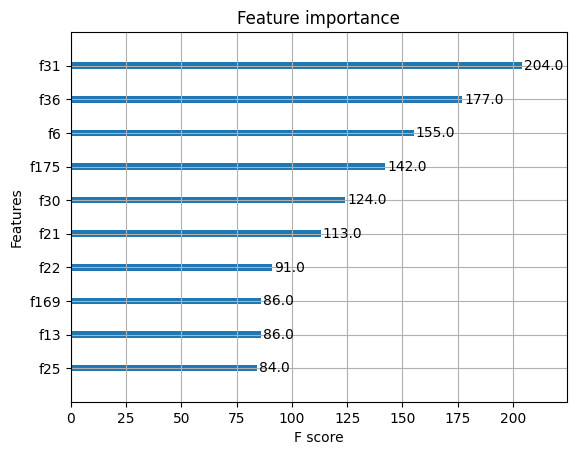

In [8]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report


#xgboost
xgb_model = xgb.XGBClassifier(
      learning_rate= 0.01,
      subsample=0.2,
      colsample_bytree=0.5,
      
)

xgb_model.fit(x_resampled, y_resampled)
y_pred = xgb_model.predict(x_test)
accuracy = xgb_model.score(x_test, y_test)
print(classification_report(y_test, y_pred))

xgb.plot_importance(xgb_model, max_num_features=10)


In [229]:
from xgboost import cv

data_dmatrix = xgb.DMatrix(data=x,label=y)

params = {"objective":"binary:logistic",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

xgb_cv = cv(dtrain=data_dmatrix, params=params, nfold=10,
                    num_boost_round=50, early_stopping_rounds=10, metrics="auc", as_pandas=True, seed=1)

xgb_cv.head()

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.699141,0.006007,0.685851,0.022543
1,0.735485,0.005199,0.718116,0.027919
2,0.753128,0.004573,0.730387,0.027861
3,0.758721,0.004096,0.739072,0.029198
4,0.770041,0.003173,0.751774,0.027649


## The cell below is **NOT** to be removed
##### The function is to be amended so that it accepts the given input (dataframe) and returns the required output (list). 
##### It is recommended to test the function out prior to submission
-------------------------------------------------------------------------------------------------------------------------------
##### The hidden_data parsed into the function below will have the same layout columns wise as the dataset *SENT* to you
##### Thus, ensure that steps taken to modify the initial dataset to fit into the model are also carried out in the function below

In [76]:
def testing_hidden_data(hidden_data: pd.DataFrame) -> list:
    '''DO NOT REMOVE THIS FUNCTION.

The function accepts a dataframe as input and return an iterable (list)
of binary classes as output.

The function should be coded to test on hidden data
and should include any preprocessing functions needed for your model to perform. 
    
All relevant code MUST be included in this function.'''
    result = [] 
    return result

##### Cell to check testing_hidden_data function

In [77]:
# This cell should output a list of predictions.
test_df = pd.read_parquet(filepath)
test_df = test_df.drop(columns=["f_purchase_lh"])
print(testing_hidden_data(test_df))

[]


### Please have the filename renamed and ensure that it can be run with the requirements above being met. All the best!